# Introduction to TensorFlow

> Convolutional Neural Networks with TensorFlow Keras

郭耀仁

## 大綱

- 關於 Convolutional Neural Networks
- 取得資料
- 建構 tf.keras 模型
- 訓練
- 隨堂練習

## 關於 Convolutional Neural Networks

## 有別於 Fully Connected Deep Network

Convolutional Neural Networks(CNN) 並非只有單純的 Input、Hidden、Output layers

## 標準的 Convolutional Neural Networks 結構

![](img/0601.png)

Source: [TensorFlow for Deep Learning](https://www.amazon.com/TensorFlow-Deep-Learning-Regression-Reinforcement/dp/1491980451)

## 各司其職的 Layers

- 輸入層
- 卷積層（Convolution Layer）：透過套用濾鏡矩陣提取圖片特徵
- 池化層 (Pooling Layer)：減少需要訓練的參數、並確定提取的特徵能夠被保留下來
- 平坦層（Flatten Layer）：為最後輸入多層感知器準備
- 多層感知器（Fully-Connected Deep Network）
- 輸出層

## 卷積層示意

![](img/0602.gif)

Source: [Artificial Inteligence](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/convolution.html)

## 池化層示意

![](img/0603.png)

Source: [Quora](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks)

## 機器學習會產生配適問題

![](img/0604.png)

Source: [What is underfitting and overfitting in machine learning and how to deal with it](https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76)

## 一般機器學習利用正規化（regularization）避免過度配適，神經網路則使用 Dropout

![](img/0605.png)

Source: [TensorFlow for Deep Learning](https://www.amazon.com/TensorFlow-Deep-Learning-Regression-Reinforcement/dp/1491980451)

## 取得資料

In [1]:
!kaggle datasets download -d zalando-research/fashionmnist --force
!unzip fashionmnist.zip

100%|███████████████████████████████████████| 68.8M/68.8M [03:43<00:00, 714kB/s]

Archive:  fashionmnist.zip
  inflating: t10k-images-idx3-ubyte  
  inflating: fashion-mnist_test.csv  
  inflating: train-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-labels-idx1-ubyte  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

ref_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
train = pd.read_csv("fashion-mnist_train.csv")

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 印出來看看

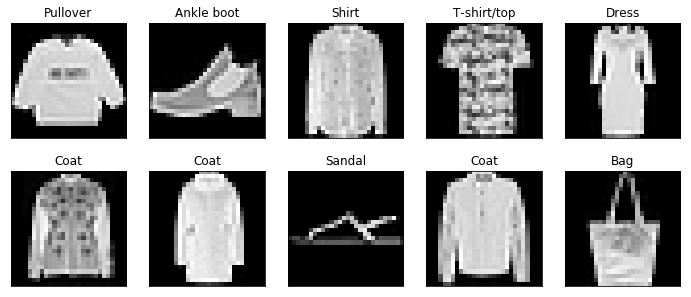

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    obs = train.loc[i, "pixel1":].values.reshape(28, -1)
    row_i, col_i = i//5, i%5
    subplot = axes[row_i, col_i]
    subplot.imshow(obs, cmap="gray")
    subplot.set_xticks([])
    subplot.set_yticks([])
    lab = train.loc[i, "label"]
    item = ref_dict[lab]
    subplot.set_title(item)
plt.show()

## 切割資料

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.loc[:, "pixel1":].values, train["label"].values, test_size=0.3, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42000, 784)
(18000, 784)
(42000,)
(18000,)


## 建構 tf.keras 模型

## 資料預處理

In [6]:
# 標準化
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [7]:
# 調整外觀
w, h = 28, 28
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)

In [9]:
import tensorflow as tf

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [10]:
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print(X_train.shape[0], 'train set')
print(X_test.shape[0], 'test set')

X_train shape: (42000, 28, 28, 1) y_train shape: (42000, 10)
42000 train set
18000 test set


## 卷積神經網絡架構

- 輸入層：解析度 28x28 的 Fashionmnist 圖片（784 個神經元）
- 第一層是 Convolution 層（64 個神經元），會利用解析度 2x2 的濾鏡取出 196 個特徵，然後將圖片降維成解析度 14x14
- 第二層是 Convolution 層（32 個神經元），會利用解析度 2x2 的濾鏡取出 49 個特徵，然後將圖片降維成解析度 7x7
- 第三層是平坦層（256 個神經元），會將圖片的特徵攤平
- 輸出結果之前使用 Dropout 函數避免過度配適
- 第四層是輸出層（10 個神經元），使用 Softmax 函數

## 使用 `Sequential` 模型 API 建構 CNN 模型

In [11]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)  

## 編譯模型

In [12]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## 訓練

In [14]:
model.fit(X_train,
          y_train,
          batch_size=64,
          epochs=5,
          validation_data=(X_test, y_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 79s 2ms/sample - loss: 0.5463 - acc: 0.8008 - val_loss: 0.3874 - val_acc: 0.8641
Epoch 2/5
42000/42000 [==============================] - 77s 2ms/sample - loss: 0.4348 - acc: 0.8419 - val_loss: 0.3593 - val_acc: 0.8638
Epoch 3/5
42000/42000 [==============================] - 77s 2ms/sample - loss: 0.3881 - acc: 0.8602 - val_loss: 0.3075 - val_acc: 0.8863
Epoch 4/5
42000/42000 [==============================] - 76s 2ms/sample - loss: 0.3656 - acc: 0.8683 - val_loss: 0.2924 - val_acc: 0.8936
Epoch 5/5
42000/42000 [==============================] - 67s 2ms/sample - loss: 0.3393 - acc: 0.8756 - val_loss: 0.2783 - val_acc: 0.8969


## 準確率

In [15]:
score = model.evaluate(X_test, y_test)

18000/18000 [==============================] - 5s 283us/sample - loss: 0.2783 - acc: 0.8969


In [16]:
print('Test accuracy: {:.2f}%'.format(score[1] * 100))

Test accuracy: 89.69%


## 觀察預測

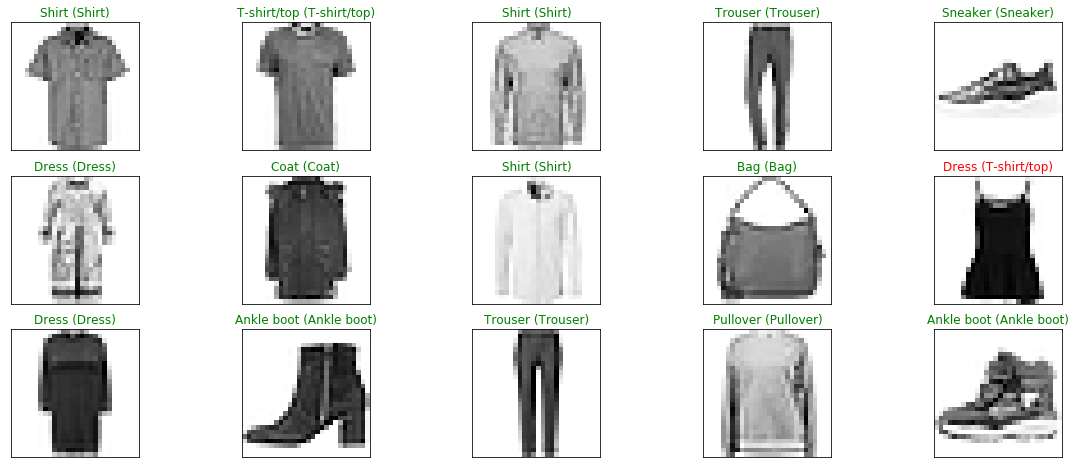

In [18]:
import numpy as np

y_hat = model.predict(X_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]), cmap="Greys")
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(ref_dict[predict_index], 
                                  ref_dict[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## 隨堂練習

## 使用 Kaggle 的 Fashinmnist 資料集並利用 tf.keras 建立一個 Convolutional Neural Network Classifier